In [68]:
import pandas as pd

# step 1: Load and concatenate the datasets
csv_files = [
    "NBA_2024_October.csv",
    "NBA_2024_November.csv",
    "NBA_2024_December.csv",
    "NBA_2025_January.csv",
    "NBA_2025_February.csv",
    "NBA_2025_March.csv",
    "NBA_2025_April.csv"
]

dfs = [pd.read_csv(file) for file in csv_files]
df = pd.concat(dfs, ignore_index=True)

# step 2: Rename columns for clarity
df = df.rename(columns={
    "Visitor/Neutral": "Away_Team",
    "PTS": "Away_PTS",
    "Home/Neutral": "Home_Team",
    "PTS.1": "Home_PTS"
})

# step 3: Drop rows with missing scores
df = df.dropna(subset=["Away_PTS", "Home_PTS"])

# step 4: Convert points to numeric (if needed)
df["Away_PTS"] = pd.to_numeric(df["Away_PTS"], errors="coerce")
df["Home_PTS"] = pd.to_numeric(df["Home_PTS"], errors="coerce")

# step 5: Recalculate outcome
df["HOME_TEAM_WIN"] = (df["Home_PTS"] > df["Away_PTS"]).astype(int)

# step 6: Parse date and sort chronologically
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date")

# step 7: Long format for rolling stats
home_df = df[["Date", "Home_Team", "Home_PTS", "Away_PTS", "HOME_TEAM_WIN"]].copy()
home_df.columns = ["Date", "Team", "PTS_FOR", "PTS_AGAINST", "WIN"]

away_df = df[["Date", "Away_Team", "Away_PTS", "Home_PTS", "HOME_TEAM_WIN"]].copy()
away_df.columns = ["Date", "Team", "PTS_FOR", "PTS_AGAINST", "WIN"]
away_df["WIN"] = 1 - away_df["WIN"]  # Flip for away

# step 8: Combine & compute rolling features
team_games = pd.concat([home_df, away_df]).sort_values(["Team", "Date"])
team_games["AVG_PTS_LAST5"] = team_games.groupby("Team")["PTS_FOR"].transform(lambda x: x.shift().rolling(5).mean())
team_games["AVG_PTS_ALLOWED_LAST5"] = team_games.groupby("Team")["PTS_AGAINST"].transform(lambda x: x.shift().rolling(5).mean())
team_games["WIN_RATE_LAST5"] = team_games.groupby("Team")["WIN"].transform(lambda x: x.shift().rolling(5).mean())

# step 9: Prepare to merge back
home_features = team_games.rename(columns={
    "Team": "Home_Team",
    "AVG_PTS_LAST5": "HOME_AVG_PTS_LAST5",
    "AVG_PTS_ALLOWED_LAST5": "HOME_AVG_ALLOWED_LAST5",
    "WIN_RATE_LAST5": "HOME_WIN_RATE_LAST5"
})[["Date", "Home_Team", "HOME_AVG_PTS_LAST5", "HOME_AVG_ALLOWED_LAST5", "HOME_WIN_RATE_LAST5"]]

away_features = team_games.rename(columns={
    "Team": "Away_Team",
    "AVG_PTS_LAST5": "AWAY_AVG_PTS_LAST5",
    "AVG_PTS_ALLOWED_LAST5": "AWAY_AVG_ALLOWED_LAST5",
    "WIN_RATE_LAST5": "AWAY_WIN_RATE_LAST5"
})[["Date", "Away_Team", "AWAY_AVG_PTS_LAST5", "AWAY_AVG_ALLOWED_LAST5", "AWAY_WIN_RATE_LAST5"]]

# step 10: Merge into the main dataframe
df = df.merge(home_features, on=["Date", "Home_Team"], how="left")
df = df.merge(away_features, on=["Date", "Away_Team"], how="left")

df.head(10)


,Date,Start (ET),Away_Team,Away_PTS,Home_Team,Home_PTS,Unnamed: 6,Unnamed: 7,Attend.,LOG,Arena,Notes,HOME_TEAM_WIN,HOME_AVG_PTS_LAST5,HOME_AVG_ALLOWED_LAST5,HOME_WIN_RATE_LAST5,AWAY_AVG_PTS_LAST5,AWAY_AVG_ALLOWED_LAST5,AWAY_WIN_RATE_LAST5
0,2024-10-22,7:30p,New York Knicks,109.0,Boston Celtics,132.0,Box Score,NaN,"19,156",2:04,TD Garden,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-10-22,10:00p,Minnesota Timberwolves,103.0,Los Angeles Lakers,110.0,Box Score,NaN,"18,997",2:26,Crypto.com Arena,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-10-23,10:00p,Golden State Warriors,140.0,Portland Trail Blazers,104.0,Box Score,NaN,"19,480",2:17,Moda Center,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-10-23,9:00p,Memphis Grizzlies,126.0,Utah Jazz,124.0,Box Score,NaN,"18,175",2:33,Delta Center,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-10-23,8:00p,Chicago Bulls,111.0,New Orleans Pelicans,123.0,Box Score,NaN,"18,581",2:11,Smoothie King Center,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN
5,2024-10-23,8:00p,Charlotte Hornets,110.0,Houston Rockets,105.0,Box Score,NaN,"18,055",2:20,Toyota Center,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
6,2024-10-23,10:00p,Phoenix Suns,116.0,Los Angeles Clippers,113.0,Box Score,OT,"18,300",2:45,Intuit Dome,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
7,2024-10-23,7:30p,Milwaukee Bucks,124.0,Philadelphia 76ers,109.0,Box Score,NaN,"19,754",2:28,Wells Fargo Center,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
8,2024-10-23,7:30p,Orlando Magic,116.0,Miami Heat,97.0,Box Score,NaN,"19,630",2:31,Kaseya Center,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
9,2024-10-23,7:30p,Brooklyn Nets,116.0,Atlanta Hawks,120.0,Box Score,NaN,"17,548",2:33,State Farm Arena,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
# Drop games where rolling averages are NaN
df_model = df.dropna(subset=[
    "HOME_AVG_PTS_LAST5", "HOME_AVG_ALLOWED_LAST5", "HOME_WIN_RATE_LAST5",
    "AWAY_AVG_PTS_LAST5", "AWAY_AVG_ALLOWED_LAST5", "AWAY_WIN_RATE_LAST5"
])


In [71]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Features & target
features = [
    "HOME_AVG_PTS_LAST5", "HOME_AVG_ALLOWED_LAST5", "HOME_WIN_RATE_LAST5",
    "AWAY_AVG_PTS_LAST5", "AWAY_AVG_ALLOWED_LAST5", "AWAY_WIN_RATE_LAST5"
]
X = df_model[features]
y = df_model["HOME_TEAM_WIN"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)

print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_log))

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.61      0.52      0.56       106
           1       0.66      0.74      0.70       134

    accuracy                           0.64       240
   macro avg       0.64      0.63      0.63       240
weighted avg       0.64      0.64      0.64       240

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.56      0.53      0.54       106
           1       0.64      0.67      0.66       134

    accuracy                           0.61       240
   macro avg       0.60      0.60      0.60       240
weighted avg       0.61      0.61      0.61       240



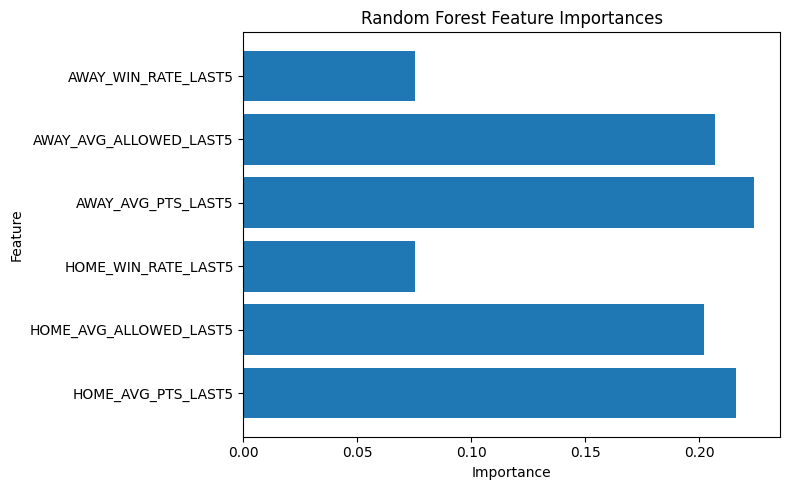

In [72]:
import matplotlib.pyplot as plt

importances = rf.feature_importances_
feat_names = X.columns

plt.figure(figsize=(8, 5))
plt.barh(feat_names, importances)
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [77]:
# Point Spread = Home avg pts - Away avg pts
df["POINT_SPREAD"] = df["HOME_AVG_PTS_LAST5"] - df["AWAY_AVG_PTS_LAST5"]

# Win Rate Diff = Home win rate - Away win rate
df["WIN_RATE_DIFF"] = df["HOME_WIN_RATE_LAST5"] - df["AWAY_WIN_RATE_LAST5"]

feature_cols = [
    "HOME_AVG_PTS_LAST5", "HOME_AVG_ALLOWED_LAST5", "HOME_WIN_RATE_LAST5",
    "AWAY_AVG_PTS_LAST5", "AWAY_AVG_ALLOWED_LAST5", "AWAY_WIN_RATE_LAST5",
    "POINT_SPREAD", "WIN_RATE_DIFF"
]

X = df[feature_cols]
y = df["HOME_TEAM_WIN"]

# Drop rows with missing values (first few games per team)
X = X.dropna()
y = y.loc[X.index]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report

hgb = HistGradientBoostingClassifier()
hgb.fit(X_train, y_train)
y_pred = hgb.predict(X_test)

print("HistGradientBoosting Results:")
print(classification_report(y_test, y_pred))


HistGradientBoosting Results:
              precision    recall  f1-score   support

           0       0.57      0.53      0.55       106
           1       0.65      0.68      0.66       134

    accuracy                           0.61       240
   macro avg       0.61      0.60      0.60       240
weighted avg       0.61      0.61      0.61       240



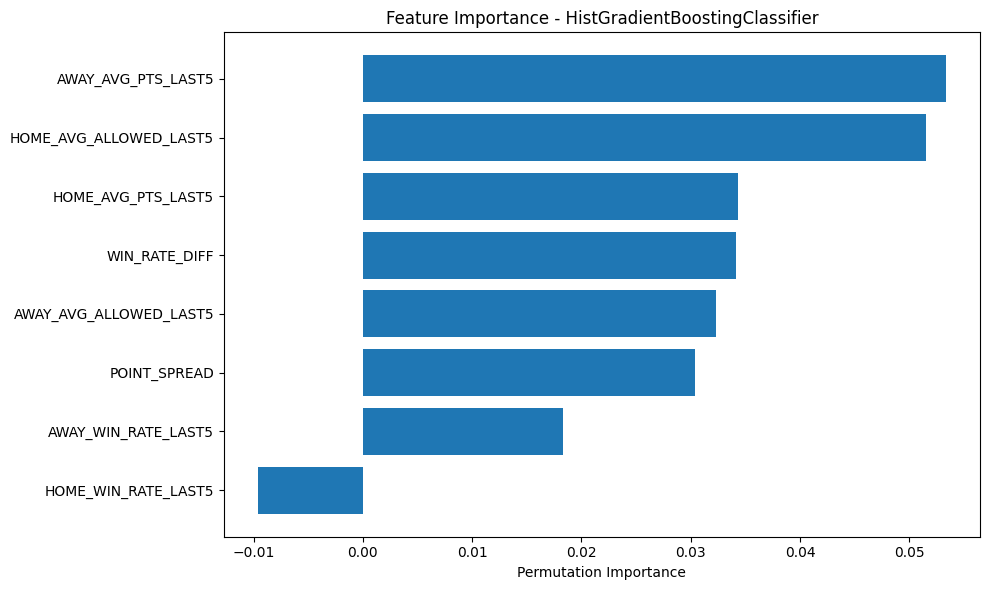

In [78]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Compute permutation importance
perm_importance = permutation_importance(hgb, X_test, y_test, n_repeats=30, random_state=42)

# Sort features by importance
sorted_idx = perm_importance.importances_mean.argsort()[::-1]
top_features = X_train.columns[sorted_idx]
top_importances = perm_importance.importances_mean[sorted_idx]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_features, top_importances)
plt.xlabel("Permutation Importance")
plt.title("Feature Importance - HistGradientBoostingClassifier")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:31:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


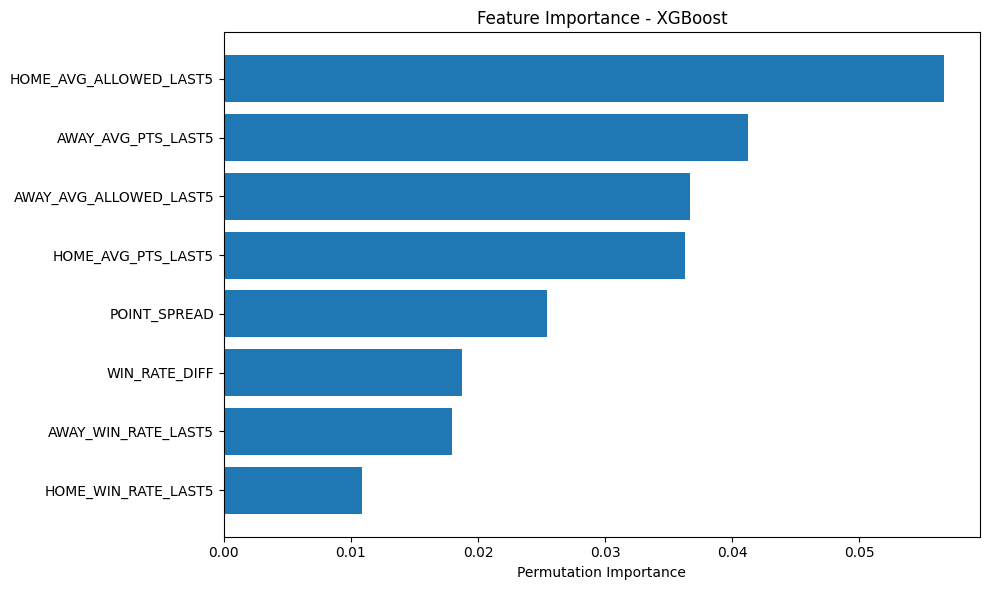

({'0': {'precision': 0.5434782608695652,
   'recall': 0.4716981132075472,
   'f1-score': 0.5050505050505051,
   'support': 106.0},
  '1': {'precision': 0.6216216216216216,
   'recall': 0.6865671641791045,
   'f1-score': 0.6524822695035462,
   'support': 134.0},
  'accuracy': 0.5916666666666667,
  'macro avg': {'precision': 0.5825499412455935,
   'recall': 0.5791326386933258,
   'f1-score': 0.5787663872770257,
   'support': 240.0},
  'weighted avg': {'precision': 0.58710830395613,
   'recall': 0.5916666666666667,
   'f1-score': 0.5873665735367862,
   'support': 240.0}},
 0.5916666666666667)

In [80]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Train XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Predict
y_pred = xgb_model.predict(X_test)

# Evaluation
report = classification_report(y_test, y_pred, output_dict=True)
accuracy = accuracy_score(y_test, y_pred)

# Permutation Importance
perm = permutation_importance(xgb_model, X_test, y_test, n_repeats=10, random_state=42)
importances = perm.importances_mean
features = X.columns

# Plot feature importance
sorted_idx = importances.argsort()
plt.figure(figsize=(10, 6))
plt.barh(features[sorted_idx], importances[sorted_idx])
plt.title("Feature Importance - XGBoost")
plt.xlabel("Permutation Importance")
plt.tight_layout()
plt.show()

report, accuracy


In [81]:
from sklearn.model_selection import GridSearchCV


# Define parameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2]
}

# Initialize base model
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Fit on training data
grid_search.fit(X_train, y_train)

# Best model
best_xgb = grid_search.best_estimator_

# Predict and evaluate
y_pred = best_xgb.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)
report_text = classification_report(y_test, y_pred)

report_text, grid_search.best_params_


c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:36:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


('              precision    recall  f1-score   support\n\n           0       0.60      0.47      0.53       106\n           1       0.64      0.75      0.69       134\n\n    accuracy                           0.63       240\n   macro avg       0.62      0.61      0.61       240\nweighted avg       0.63      0.63      0.62       240\n',
 {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50})